<a href="https://colab.research.google.com/github/gzguevara/amex_kaggle/blob/master/Train_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Drive and XGB

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip uninstall xgboost
!pip install xgboost

#!pip install import_ipynb
#import import_ipynb

Mounted at /content/drive
Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 192.9 MB 52 kB/s 


# Imports

In [11]:
import pandas as pd
import numpy  as np  
import cupy
# for cupu memory managmet
mempool        = cupy.get_default_memory_pool()
pinned_mempool = cupy.get_default_pinned_memory_pool()

import xgboost as xgb
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import sys
from importlib import reload #test = reload(test)

import matplotlib.pyplot as plt, gc, os
import plotly.express as px
import seaborn as sns

import random
import itertools

# Paths
train_dir   = '/content/drive/MyDrive/KaggleAMEX/Data/train.parquet'
impor_dir   = '/content/drive/MyDrive/KaggleAMEX/Importance'
targets_dir = '/content/drive/MyDrive/KaggleAMEX/Data/train_labels.csv'

#Parameters
SEED  = 42
FOLDS = 5

#Get numerical and catecorical columns 

cat_features = ['B_30', 'B_38', 'D_117', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', 'B_33', 'D_92', 'D_103', 'R_27', 'D_114', 'D_116', 'D_129', 'D_139', 'D_140', 'D_143', 'B_8', 'D_51', 'D_54', 'D_65', 'B_16', 'B_22', 'D_72', 'D_78', 'D_79', 'R_9', 'D_82', 'D_107', 'D_122', 'D_125']
bin_features = ['R_2', 'S_6', 'R_4', 'R_15', 'S_18', 'D_86', 'D_87', 'B_31', 'R_19', 'B_32', 'S_20', 'R_21', 'R_22', 'R_23', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'D_127', 'R_28', 'D_109', 'D_120', 'D_135', 'D_137', 'R_7', 'R_12', 'R_14', 'D_112']
num_features = ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'D_50', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'D_70', 'D_71', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'D_77', 'B_25', 'B_26', 'R_8', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'S_17', 'B_28', 'R_13', 'D_83', 'D_84', 'R_16', 'B_29', 'R_17', 'R_18', 'D_88', 'S_19', 'R_20', 'D_89', 'D_91', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_104', 'D_105', 'D_106', 'B_36', 'B_37', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'B_40', 'S_27', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_123', 'D_124', 'D_128', 'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_136', 'D_138', 'D_141', 'D_142', 'D_144', 'D_145']

# Data

In [83]:
def process_and_feature_engineer(cus_range, obs):

    # 13
    frequency = pd.read_csv('/content/drive/MyDrive/KaggleAMEX/Data/train/frequency.csv', index_col=0)
    customers = frequency.loc[frequency.frequency.isin(cus_range)].index.values
    
    # num - mean, std, min, max, last, first  cat - last, unique
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/train/base_variables.parquet'
    df  = pd.read_parquet(dir)
    df  = df.loc[customers]
    # replace categorial
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/train/base_variables_cat_woe.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df[new.columns] = new
    print('Done base', df.shape)
    
    # p_b_s_r_d variables corr and cat/bin sum 
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/train/p_b_s_r_d.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers, ['R_sum_num', 'S_bin_sum', 'D_bin_sum', 'R_bin_sum', 'B_cat_sum', 'D_cat_sum']]
    df  = pd.concat([new, df], axis=1)
    print('Done p_b_s_r_d variables', df.shape)
    
    # count na & not na values
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/train/na_dummies.parquet' #('/content/drive/MyDrive/KaggleAMEX/Data/mean_na.parquet')
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df  = pd.concat([new, df], axis=1)
    print('Done count na variables', df.shape)

    # non linear numerical
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/train/nonlinear.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df  = pd.concat([new, df], axis=1)
    print('Done non linear', df.shape)

    # First difference of last values 
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/train/first_diff.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df  = pd.concat([new, df], axis=1)
    print('Done diff_1 variables', df.shape)
    
    # Sum woe numerical
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/train/num_woe_sum.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df  = pd.concat([new, df], axis=1)
    print('Done sum woe', df.shape)

    # Advanced
    dir = '/content/drive/MyDrive/KaggleAMEX/Data/train/advanced.parquet'
    new = pd.read_parquet(dir)
    new = new.loc[customers]
    df  = pd.concat([new, df], axis=1)
    print('Done advanced features', df.shape)

    # Add targets
    targets      = pd.read_csv(targets_dir, usecols = ['target']).astype('int8')
    df['target'] = targets.loc[customers]

    # Drop na columns
    to_drop = [x for x in df.columns if len(df[x].unique())==1]
    df.drop(to_drop, axis=1, inplace=True)
    print(f'Droped {len(to_drop)} features. New Shape:', df.shape)

    # Reset index
    df.reset_index(drop=True, inplace=True)

    # Downsample majority class
    df_majority = df.loc[df.target == 0]
    df_minority = df.loc[df.target == 1]

    df_majority = resample(df_majority, 
                          replace      = False,    
                          n_samples    = int(obs/2),  #df_minority.shape[0],
                          random_state = SEED)
    
    df_minority = resample(df_minority, 
                          replace      = False,    
                          n_samples    = int(obs/2), 
                          random_state = SEED)
    
    df = pd.concat([df_majority, df_minority])
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    print('Downsampled to', df.shape)

    return df

# Read & Transform Data 

In [84]:
train = process_and_feature_engineer(cus_range=list(range(2,13)), obs=6000)

Done base (67759, 829)
Done p_b_s_r_d variables (67759, 835)
Done count na variables (67759, 1024)
Done non linear (67759, 1206)
Done diff_1 variables (67759, 1352)
Done sum woe (67759, 1479)
Done advanced features (67759, 1724)
Droped 72 features. New Shape: (67759, 1652)
Downsampled to (6000, 1652)


# Extreme Gradient Boost

### Custom metric & permutation importance

In [4]:
# This is the metric given by rules
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)


    return 0.5 * (gini[1]/gini[0] + top_four)
    

# Metric for XGB
def xgboost_amex_metric_mod(predt: np.ndarray, dtrain: xgb.DMatrix):
    y = dtrain.get_label()
    return 'AMEXcustom', 1-amex_metric_mod(y, predt)

def permutation_importance(train, valid_idx, features, model, kag_mets):

    # Permutation importance
    x_test  = train.loc[valid_idx, train.columns[:-1]]
    y_test  = train.loc[valid_idx, 'target']
    metrics = []

    for column, feature in enumerate(features):

          #Save original feature
          original_feature = x_test[feature].copy()
          metric = []

          for i in range(1):

              # Shuffel
              x_test[feature] = np.random.permutation(original_feature)

              #Build DMatrix
              dvalid = xgb.DMatrix(data=cupy.array(x_test))
              
              #Predict
              preds  = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
              metric.append(kag_mets - amex_metric_mod(y_test, preds))

          metrics.append(np.mean(metric))

          #Rebuild data
          x_test[feature] = original_feature
    
    return metrics

### Get grid & feature order

In [87]:
learning_rate     = [0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06]          
gamma             = [0, 0.005, 0.01, 0.0115, 0.012, 0.0125, 0.013, 0.0135, 0.03]

max_depth         = [4,5,6]                     
max_leaves        = [0, 20, 30]             
max_bin           = [200]               

subsample         = [0.2, 0.3, 0.4]   
sampling_method   = ['gradient_based'] #'uniform', 

colsample_bytree  = [1]             
colsample_bylevel = [1]             
colsample_bynode  = [0.1, 0.2, 0.3, 0.4]             
                   
alpha             = [0, 0.5, 1, 1.25, 1.5, 1.75, 2]             
lambda_           = [1, 1.25, 1.5, 1.75, 2, 2.5, 2.75, 3]             

min_child_weight  = [1.25, 1.5, 1.75]    
scale_pos_weight  = [1]

grow_policy       = ['depthwise']

tree_method       = ['gpu_hist']        
objective         = ['binary:logistic']
predictor         = ['gpu_predictor']
seed              = [SEED]

booster           = ['dart']
sample_type       = ['uniform', 'weighted']
normalize_type    = ['tree', 'forest']
rate_drop         = [0.1, 0.2]
skip_drop         = [0.5, 0.6]


# Get Grids for xgb
hyper_parms = ['grow_policy', 'learning_rate', 'gamma', 'max_depth', 'min_child_weight', 'subsample', 'sampling_method', 'colsample_bytree', 'colsample_bylevel', 'colsample_bynode', 'lambda', 'alpha', 'scale_pos_weight', 'max_leaves', 'max_bin', 'tree_method', 'objective', 'predictor', 'seed']#, 'booster', 'sample_type', 'normalize_type', 'rate_drop', 'skip_drop']
variants    = list(itertools.product(grow_policy, learning_rate, gamma, max_depth, min_child_weight, subsample, sampling_method, colsample_bytree, colsample_bylevel, colsample_bynode, lambda_, alpha, scale_pos_weight, max_leaves, max_bin, tree_method, objective, predictor, seed))#, booster, sample_type, normalize_type, rate_drop, skip_drop))
xgb_grid    = [dict(zip(hyper_parms, variant)) for variant in variants]
random.shuffle(xgb_grid)
xgb_grid = xgb_grid[:2]

print(f'There are {len(xgb_grid)} different Models.', '\n', '\n')

There are 2 different Models. 
 



In [30]:
premu_order = premu_order.loc[premu_order.avg > 0].copy()

In [32]:
train = train[premu_order.index.to_list() + ['target']]

In [33]:
premu_order['weight'] = [0] * premu_order.shape[0]

In [34]:
premu_order['weight'] = premu_order['avg']

In [37]:
premu_order.loc[premu_order.avg>0.00065, 'weight'] = premu_order.loc[premu_order.avg>0.00065, 'weight'] + 0.01

In [38]:
premu_order['weight'] = premu_order.weight / premu_order.weight.sum()

In [86]:
# Get orders
orders  = []

weights = [1/len(train.columns[:-1])] * len(train.columns[:-1]) #premu_order.weight.to_list()     # 
cols    = train.columns[:-1].to_list()   #train.columns[:-1].to_list() 

join = list(zip(cols, weights))

for order in range(3):

  random.shuffle(join)
  orders.append(join.copy())

print(f'There are {len(orders)} different order.', '\n', '\n')

There are 3 different order. 
 



### Search & Permutation Importance

In [ ]:
# Out-of-fold predictions & permutation  importances
oof_cols  = [f'fold_{i}' for i in range(FOLDS)] + ['avg', 'oof']
oof       = pd.DataFrame(columns = oof_cols)
premu_imp = pd.DataFrame()

# Get feature order & weights
for order_num, order in enumerate(orders):

      weights     = [x[1] for x in order]
      features    = [x[0] for x in order]
      train       = train[features + ['target']]
      premu_order = pd.DataFrame(index=train.columns[:-1])

      # Start grid search
      for model_num, xgb_parms in enumerate(xgb_grid):

            kag_mets  = []
            oof_model = pd.DataFrame()

            # Start cross validation
            skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=11)
            for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train.target)):
                
                  print(f'########### Order {order_num} Model {model_num} Fold {fold} #############')
                  print('##################################################')
                  
                  # Train and valid set for given fold       
                  x_valid = cupy.array(train.loc[valid_idx, train.columns[:-1]])
                  y_valid = cupy.array(train.loc[valid_idx, 'target'])
                  dvalid  = xgb.DMatrix(data=x_valid, label=y_valid)
                  
                  x_train = cupy.array(train.loc[train_idx, train.columns[:-1]])
                  y_train = cupy.array(train.loc[train_idx, 'target'])
                  dtrain  = xgb.DeviceQuantileDMatrix(data=x_train, label=y_train, feature_weights=weights)

                  # Train model
                  model = xgb.train(params                = xgb_parms,
                                    dtrain                = dtrain,
                                    evals                 = [(dvalid,'valid')],
                                    custom_metric         = xgboost_amex_metric_mod,
                                    num_boost_round       = 10000,
                                    early_stopping_rounds = 300,
                                    verbose_eval          = 500)
                
                  # Save model
                  model_dir = '/content/drive/MyDrive/KaggleAMEX/Models/freq_3'
                  model.save_model(f'{model_dir}/avg_fold_{fold}.xgb')
                          
                  # Validation - Infer out-of-fold
                  preds     = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
                  df        = pd.DataFrame(data=preds, index=valid_idx, columns=['oof'])
                  oof_model = pd.concat([oof_model, df], axis = 0)

                  # Kaggle metric
                  kag_mets.append(amex_metric_mod(y_valid.get(), preds))
                  curr_best = np.max([oof[f'fold_{fold}'].max(), kag_mets[-1]])
                  print(f'Metric = {kag_mets[-1]}, Best = {curr_best}', '\n')
                  
                  # Skip if no significant improvment
                  #if kag_mets[-1] + 0.011 < curr_best: break
                  
                  # Permutation importance
                  premu_order[f'order_{order_num}_grid_{model_num}_fold_{fold}'] = permutation_importance(train, valid_idx, train.columns[:-1], model, kag_mets[-1])
                  
                  # Clean RAM & GPU RAM
                  del y_train, x_train, y_valid, x_valid, dtrain, dvalid, train_idx, valid_idx
                  mempool.free_all_blocks(), pinned_mempool.free_all_blocks(), gc.collect()
                    
            # Skip if fold not compleat
            if len(kag_mets) != 5: continue
          
            # Metrics
            kag_mets.append(np.mean(kag_mets))
            kag_mets.append(amex_metric_mod(train.target.values, oof_model.sort_index().oof.values))
            oof.loc[f'order_{order_num}_model_{model_num}'] = kag_mets
            print(f'avg: {kag_mets[-2]}, Max: {oof.avg.max()}')
            print(f'oof: {kag_mets[-1]}, Max: {oof.oof.max()}', '\n', '\n', '\n')
            
      #premu_imp = pd.concat([premu_order,premu_imp], axis=1)

# Average over folds
premu_imp['avg'] = premu_imp.mean(axis=1)
premu_imp.sort_values('avg', ascending=False, inplace=True)
oof.sort_values('oof', ascending=False, inplace=True)

########### Order 0 Model 0 Fold 0 #############
##################################################
[0]	valid-logloss:0.66938	valid-AMEXcustom:0.57004
[468]	valid-logloss:0.37789	valid-AMEXcustom:0.36623
Metric = 0.6412575175529853, Best = nan 

########### Order 0 Model 0 Fold 1 #############
##################################################
[0]	valid-logloss:0.66774	valid-AMEXcustom:0.57168
[500]	valid-logloss:0.35190	valid-AMEXcustom:0.35559
[838]	valid-logloss:0.37238	valid-AMEXcustom:0.35666
Metric = 0.6525496176103385, Best = nan 



In [58]:
oof.sort_values('avg', ascending=False) # order_0_model_36 0.7456882519734114  order_0_model_135 0.742896

,fold_0,fold_1,fold_2,fold_3,fold_4,avg,oof
order_0_model_0,0.733118,0.747534,0.752498,0.732293,0.759088,0.744906,0.742896


In [ ]:
premu_imp['avg'] = premu_imp.mean(axis=1)
premu_imp.sort_values('avg', ascending=False, inplace=True)
oof.sort_values('oof', ascending=False, inplace=True)

In [23]:
premu_order['avg'] = premu_order.mean(axis=1)

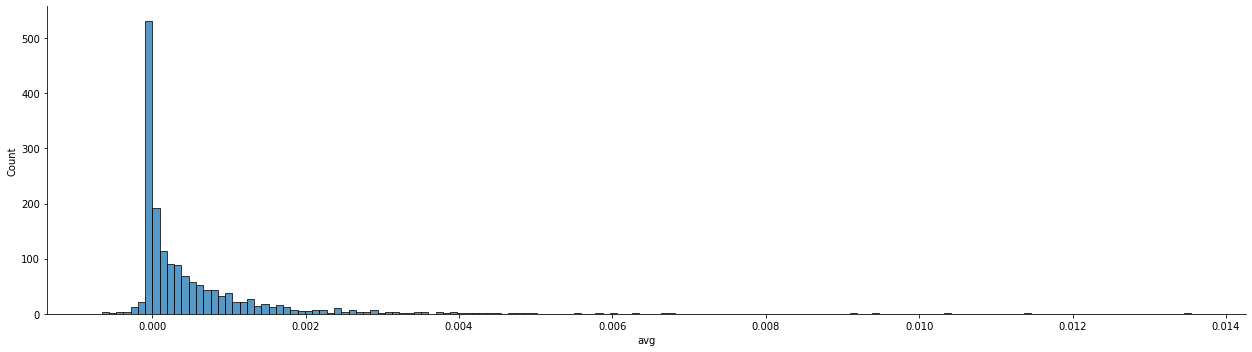

In [24]:
sns.displot(premu_order, x='avg', bins=150, height=5, legend=False,  aspect=3.5)

In [25]:
premu_order.sort_values('avg', ascending=False, inplace=True)

In [29]:
premu_order.loc[premu_order.avg <= 0]

,order_0_grid_0_fold_0,order_0_grid_0_fold_1,order_0_grid_0_fold_2,order_0_grid_0_fold_3,order_0_grid_0_fold_4,order_0_grid_1_fold_0,order_0_grid_1_fold_1,order_0_grid_1_fold_2,order_0_grid_2_fold_0,order_0_grid_2_fold_1,order_0_grid_2_fold_2,order_0_grid_5_fold_0,avg
B_15_sum_na,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
R_20_max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
D_119_sum_na,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
R_13_sum_woe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
R_18_diff_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
D_44_last_m_B_2_mean,0.000000,0.002028,0.001004,0.000000,0.000096,-0.000144,-0.002136,0.000968,0.000000,-0.005868,0.000952,-0.002301,-0.000450
R_1_t_B_7_max,-0.000060,-0.000012,0.000028,0.000012,0.000092,0.000000,0.000004,-0.006000,0.000000,0.000000,-0.000024,0.000028,-0.000494
R_1_last_m_B_2_mean,0.001008,-0.000080,-0.000040,0.000068,0.000132,-0.001108,0.002032,-0.000836,0.002032,-0.006124,0.000000,-0.004032,-0.000579
P_2_mean_m_R_1_std,0.000028,-0.006120,0.000004,-0.000024,0.000000,-0.000004,-0.000028,0.000024,-0.000080,0.000004,0.000004,-0.000996,-0.000599


In [20]:
permu_save = premu_order.copy()

# Save Parameter & Feature Order

In [68]:
parameter     = pd.DataFrame([xgb_grid[36], xgb_grid[135]], index = ['avg', 'oof'])

order_avg   = [x[0] for x in orders[0]]
weights_avg = [x[1] for x in orders[0]]

order_oof   = [x[0] for x in orders[0]]
weights_oof = [x[1] for x in orders[0]]

feature_order = pd.DataFrame(list(zip(order_avg, weights_avg, order_oof, weights_oof)), columns=['order_avg', 'weights_avg', 'order_oof', 'weights_oof'])

In [72]:
parameter.to_csv('/content/drive/MyDrive/KaggleAMEX/Models/freq_3/parameters.csv')
feature_order.to_csv('/content/drive/MyDrive/KaggleAMEX/Models/freq_3/features.csv')

In [ ]:
# [1]    order_1_model_44 - 0.641124 order_2_model_156 - 0.632451
# [2-12] order_0_model_16 - 0.671053 order_0_model_152 - 0.669303
# [13]   order_0_model_36 - 0.745688 order_0_model_135 - 0.742896

# Feature Importance

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

Gain - The relative contribution of the corresponding feature to the model. This is calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

Coverage - The relative number of observations related to this feature. For example, if you have 100 observations, 4 features and 3 trees, and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17 observations. This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features’ cover metrics.

Weight - The percentage representing the relative number of times a particular feature occurs in the trees of the model. In the above example, if feature1 occurred in 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3; then the weight for feature1 will be 2+1+3 = 6. The frequency for feature1 is calculated as its percentage weight over weights of all features.

In [ ]:
importance_types = ['cover', 'gain', 'weight', 'total_gain', 'total_cover']

In [ ]:
df = model.get_score(importance_type='cover')
df = pd.DataFrame.from_dict(df, orient='index', columns = ['cover'])

In [ ]:
df = model.get_score(importance_type='gain')
df = pd.DataFrame.from_dict(df, orient='index', columns = ['gain'])